In [0]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.names

In [0]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data

In [0]:
import scipy.sparse
import scipy
from matplotlib import pyplot as plt
import numpy as np

# Cost Functions 


In [0]:

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))


def sigmoid_prime(z):
    return z * (1 - z)


def softmax(z):
    z -= np.max(z)
    sm = (np.exp(z).T / np.sum(np.exp(z), axis=1)).T
    return sm


def softmax_prime(z):
    return


def relu(z):
    return np.maximum(z, 0)

def relu_prime(z):
    dz = np.ones_like(z)
    dz[z < 0] = 0
    return dz

# Functions for weights initializations


In [0]:
def relu_weight(m, n):
    np.random.seed(0)
    return np.random.rand(m, n) * np.sqrt(2) / np.sqrt(m)


def xavier(m, n):
    np.random.seed(0)
    return np.random.rand(m, n) / np.sqrt(m)


def he(m, n):
    np.random.seed(0)
    return np.random.rand(m, n) * np.sqrt(2) / np.sqrt(m + n)


In [0]:
class Layer(object):

  def __init__(self, n_in, n_out=10, activation_function="relu"):
        self.n_in = n_in
        self.n_out = n_out
        self.set_activation_functions(act_function_name=activation_function)

  def set_activation_functions(self, act_function_name="relu"):
      if act_function_name == "relu":
          self.activation_function = relu
          self.function = relu_prime
          self.set_weight_function(weight_name="he")
      elif act_function_name == "sigmoid":
          self.activation_function = sigmoid
          self.function = sigmoid_prime
          self.set_weight_function(weight_name="xavier")
      elif act_function_name == "softmax":
          self.activation_function = softmax
          self.function = softmax_prime
          self.set_weight_function(weight_name="he")

  def set_weight_function(self, weight_name):
      if weight_name == "relu":
          self.weight_function = relu_weight
      elif weight_name == "xavier":
          self.weight_function = xavier
      elif weight_name == "he":
          self.weight_function = he

# Multilayer Perceptron

In [0]:
class MLPModel(object):
  def __init__(self,input_neurons, output_neurons, learning_rate=0.1,n_epoch=1000,batch_size=10):
    self.input_neurons = input_neurons
    self.output_neurons = output_neurons
    self.learning_rate = learning_rate
    self.batch_size = batch_size
    self.previous_weights = []
    self.previous_biases = []
    self.layers  = []
    self.losses = []
    self.biases = []
    self.weights = []
    self.epoch = n_epoch

  def backPropogation(self, x, y_mat, a):
    m=x.shape[0]
    output = a[-1]
    loss = (-1 / m) * np.sum(y_mat * np.log(output))
    deltas = []
    delta = y_mat - output
    deltas.append(delta)
    
    for l in range(len(self.layers)-1):
        prime = self.layers[-2 - l].function(a[-2 - l])
        w = self.weights[-1-l]
        delta = np.dot(delta, w.T) * prime
        deltas.append(delta)
    
    prev_weights = self.previous_weights.pop(0)
    prev_biases = self.previous_biases.pop(0)

    
    for l in range(len(self.layers)-1):
        dw = (2/m) * np.dot(a[l].T,deltas[-1-l])
        self.weights[l] += self.learning_rate * dw
        
        db = (1/m) * np.sum(deltas[-1-l], axis=0, keepdims=True)
        self.biases[l] += self.learning_rate * db

    self.backPropogationWeights()
    return loss
  
  def backPropogationWeights(self):
    self.previous_weights.append(self.weights)
    self.previous_biases.append(self.biases)

  def addLayer(self, hidden_neurons, activation_function="sigmoid"):
    if len(self.layers) <= 0:
      n_previous_neurons = self.input_neurons
    else:
      n_previous_neurons = self.layers[-1].n_out
    
    L = Layer(n_in=n_previous_neurons, n_out=hidden_neurons, activation_function=activation_function)
    self.layers.append(L)


  def initializeWeights(self):
    for i in range(len(self.layers)):
      n_cur_layer_neurons = self.layers[i].n_out
      n_prev_layer_neurons = self.layers[i].n_in

      weights = self.layers[i].weight_function(n_prev_layer_neurons, n_cur_layer_neurons)
      self.weights.append(weights)

      biases = np.zeros((1, n_cur_layer_neurons))
      self.biases.append(biases)
  
  def forwardPropogation(self, X):
    a = [X]
    for l in range(len(self.layers)):
      z = a[l].dot(self.weights[l]) + self.biases[l]
      activation = self.layers[l].activation_function(z)
      a.append(activation)

    return a
  
  def oneHotEncoder(self,Y):
    m = Y.shape[0]
    label = scipy.sparse.csr_matrix((np.ones(m), (Y, np.array(range(m)))))
    label = np.array(label.todense()).T
    return label

  def fit(self, x, y, print_loss=True):
    self.initializeWeights()
    self.backPropogationWeights()
    y_mat = self.oneHotEncoder(y)
        
    for i in range(self.epoch):
          
      a = self.forwardPropogation(x)
      loss = self.backPropogation(x,y_mat,a)
                  
      if print_loss:
          print('Iteration: {0}  --  Loss: {1}'.format(i,loss))
          self.losses.append([i,loss])
  

  def predict(self,x):
    probs = self.forwardPropogation(x)[-1]
    preds = np.argmax(probs, axis=1)
    return probs, preds

# Util functions 
1. loss visualisations
3. accuracy score.


In [0]:
#utils

def loss_visualization(losses, title):
  errors = np.array(losses)
  plt.plot(errors[:, 0], errors[:, 1], 'r--')
  plt.title(title)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

def accuracy_score(model, x_pred, y_true):
  prob,predicted = model.predict(x_pred)
  accuracy = sum(predicted == y_true)/(float(len(y_true)))
  percentage = accuracy*100
  return percentage


def datasetSplit(data_features, data_labels, test_size=20):
  tmp_data_features = []
  tmp_data_labels = []

  for i in np.random.permutation(len(data_features)):
    tmp_data_features.append(data_features[i])
    tmp_data_labels.append(data_labels[i])

  cut_index = int(len(data_features) * (1.-(test_size/100.)))
  x_train, x_test = tmp_data_features[:cut_index], tmp_data_features[cut_index:]
  y_train,y_test = tmp_data_labels[:cut_index], tmp_data_labels[cut_index:]

  return np.asarray(x_train), np.asarray(x_test), np.asarray(y_train), np.asarray(y_test)

## The below code demonstrates the usage of the above implemeneted multi layer perceptron.

 -  Used Iris Dataset, and the task is to classify types of iris flowers given the features of the flower.

In [0]:
#load and read data

wine_data = open('wine.data')
wine_data = wine_data.read().split('\n')

wine_features = []
wine_class = []
for line in wine_data[:-1]:
  data = line.split(',')

  wine_features.append(list(map(float, data[1:])))
  wine_class.append(list(map(int, data[0])))

# features and the labels of the dataset. -> X, Y
wine_features = np.asarray(wine_features)
wine_class = np.asarray(wine_class)
wine_class_f = np.asarray([i-1 for i in wine_class]).ravel()  # --> flatten

In [0]:
# split dataset into training and testing

x_train, x_test, y_train, y_test = datasetSplit(wine_features, wine_class_f, test_size=33)

In [0]:
# normalize the training dataset 
X_std = (x_train - x_train.mean(axis=0)) / x_train.std(axis=0)

In [0]:
# build the model 
input_neurons = X_std.shape[1]
nn = MLPModel(input_neurons=input_neurons, output_neurons=3, n_epoch=15000, learning_rate=0.01)


#  Total 3 layers, 1 hidden layers, 1 input and 1 output
activation_func = "sigmoid"
nn.addLayer(hidden_neurons=50, activation_function=activation_func)
nn.addLayer(hidden_neurons=20, activation_function=activation_func)
nn.addLayer(hidden_neurons=5, activation_function=activation_func)

nn.addLayer(activation_function="softmax", hidden_neurons=3)

# train_accuracy = Accuracy(x_train,y_train)
# test_accuracy = nn.Accuracy(X_test,y_test)

In [41]:
# train the built model
nn.fit(X_std, y_train)

Iteration: 0  --  Loss: 1.1308079888218723
Iteration: 1  --  Loss: 1.1308027873141793
Iteration: 2  --  Loss: 1.1307975797545167
Iteration: 3  --  Loss: 1.1307923661311499
Iteration: 4  --  Loss: 1.130787146432317
Iteration: 5  --  Loss: 1.1307819206462242
Iteration: 6  --  Loss: 1.1307766887610522
Iteration: 7  --  Loss: 1.130771450764949
Iteration: 8  --  Loss: 1.1307662066460347
Iteration: 9  --  Loss: 1.1307609563924
Iteration: 10  --  Loss: 1.1307556999921053
Iteration: 11  --  Loss: 1.1307504374331825
Iteration: 12  --  Loss: 1.1307451687036325
Iteration: 13  --  Loss: 1.1307398937914268
Iteration: 14  --  Loss: 1.130734612684508
Iteration: 15  --  Loss: 1.1307293253707873
Iteration: 16  --  Loss: 1.1307240318381468
Iteration: 17  --  Loss: 1.1307187320744383
Iteration: 18  --  Loss: 1.1307134260674834
Iteration: 19  --  Loss: 1.1307081138050734
Iteration: 20  --  Loss: 1.1307027952749693
Iteration: 21  --  Loss: 1.130697470464902
Iteration: 22  --  Loss: 1.1306921393625715
Itera

In [42]:
# train_accuracy
train_accuracy = accuracy_score(nn,x_train,y_train)
print(train_accuracy)

34.45378151260504


In [43]:
# test_accuracy
test_accuracy = accuracy_score(nn, x_test, y_test)
print(test_accuracy)

50.847457627118644


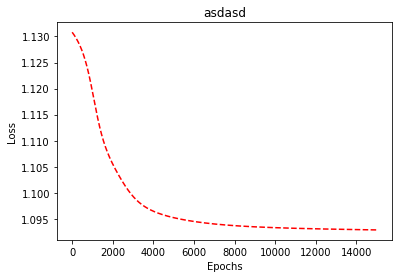

In [44]:
loss_visualization(nn.losses,"asdasd")